<a href="https://colab.research.google.com/github/Jayaprakash1710/Module-21-Computer-vision/blob/main/DJ_Lec_2_Revisiting_CNN_Dealing_With_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC

Downloading...
From (original): https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC
From (redirected): https://drive.google.com/uc?id=1XdXz0TKo_KCDRHOMvzV-YtcTx7NPG-jC&confirm=t&uuid=99b52b07-4c68-4f19-8137-26ed968af500
To: /content/clothing-dataset-small.zip
100% 106M/106M [00:02<00:00, 39.0MB/s]


In [2]:
!unzip /content/clothing-dataset-small.zip

Archive:  /content/clothing-dataset-small.zip
   creating: clothing-dataset-small/
  inflating: clothing-dataset-small/.DS_Store  
   creating: clothing-dataset-small/test/
   creating: clothing-dataset-small/test/skirt/
  inflating: clothing-dataset-small/test/skirt/f4b934fc-e326-4f72-b535-53288b8b82d3.jpg  
  inflating: clothing-dataset-small/test/skirt/491982c3-3e90-431e-99e6-b14ecea36384.jpg  
  inflating: clothing-dataset-small/test/skirt/24963db3-649c-4f04-8da3-0375ede8e0a6.jpg  
  inflating: clothing-dataset-small/test/skirt/32b99302-cec7-4dec-adfa-3d4029674209.jpg  
  inflating: clothing-dataset-small/test/skirt/0558b2c5-be00-49de-b27f-8c88114ac36f.jpg  
  inflating: clothing-dataset-small/test/skirt/95e66e02-b4ed-4fe9-b538-db6bac4fb7df.jpg  
  inflating: clothing-dataset-small/test/skirt/2001dec1-1e0a-4c11-9d15-120b019b3dea.jpg  
  inflating: clothing-dataset-small/test/skirt/b0e05193-cc92-4935-88d7-e71a1b19dd4b.jpg  
  inflating: clothing-dataset-small/test/skirt/309829b2-6d1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

import os
import glob #makes is easy to navigate folders
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.utils.set_random_seed(111)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
class_dirs = os.listdir("clothing-dataset-small/train") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'clothing-dataset-small/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

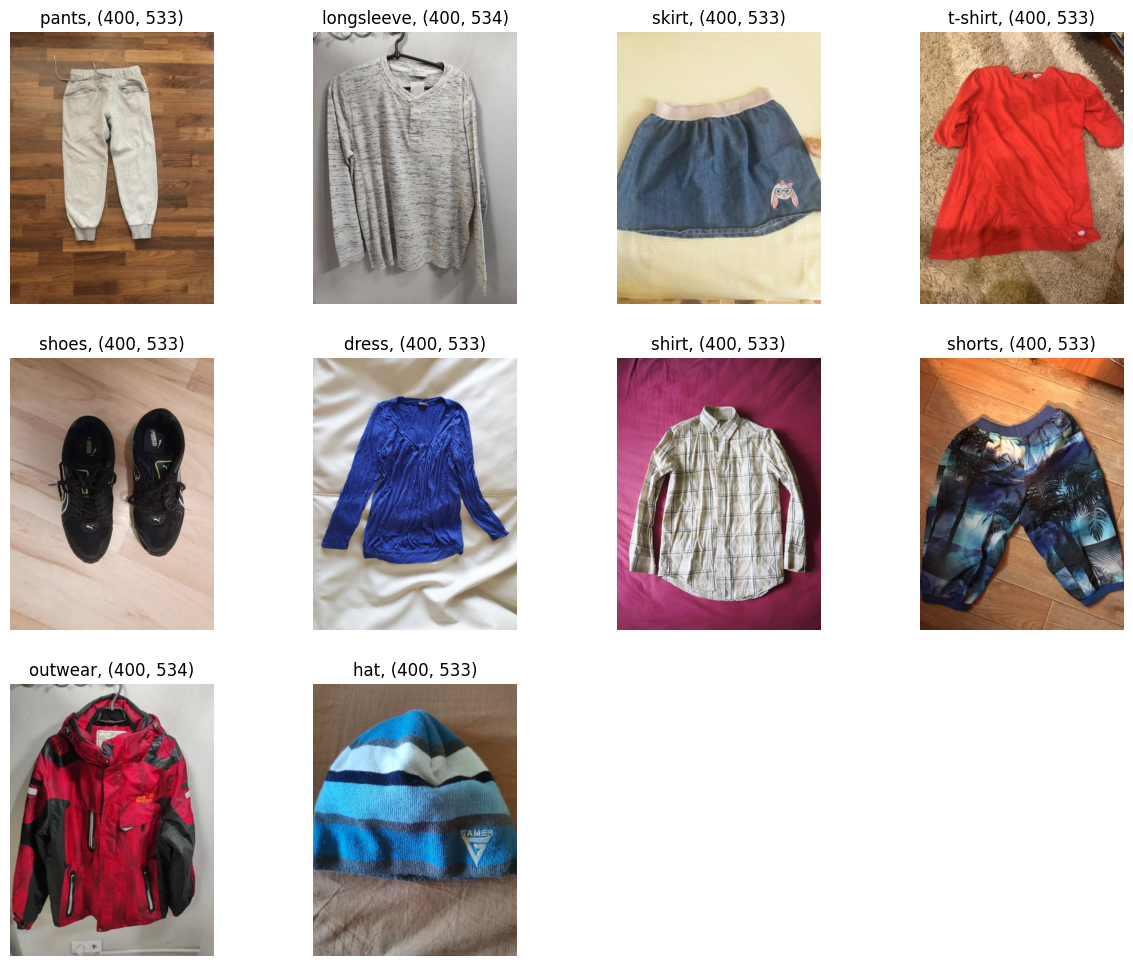

In [5]:
## Viz Random Sample from each class

plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()):
    # create a subplot axis
    ax = plt.subplot(3, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

Count of training samples per class:
         class  count
0       pants    468
1  longsleeve    455
2       skirt    112
3     t-shirt    795
4       shoes    198
5       dress    241
6       shirt    290
7      shorts    202
8     outwear    184
9         hat    123


<Axes: title={'center': 'Training Data Count per class'}, xlabel='class'>

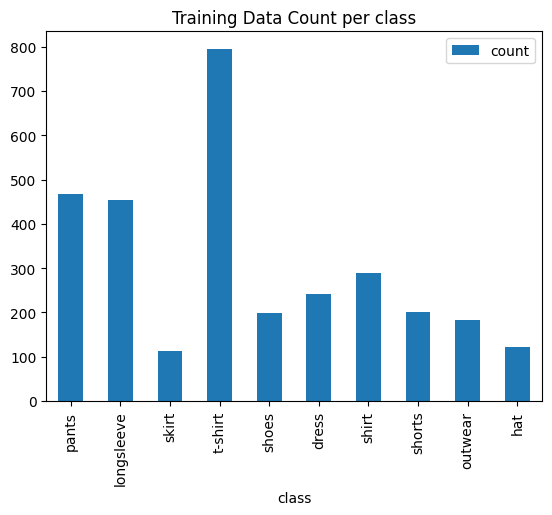

In [6]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

# draw a bar plot using pandas in-built plotting function
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class")

The probability of randomly picking any class is 1/10. So, the accuracy of our model should not go below 10%

In [7]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "clothing-dataset-small/test", shuffle = False,
)


Loading Train Data...
Found 3068 files belonging to 10 classes.

Loading Validation Data...
Found 341 files belonging to 10 classes.

Loading Test Data...
Found 372 files belonging to 10 classes.


In [8]:
height, width = 128, 128 # Optional, not required if we already have resized the data from `image_dataset_from_directory` function.

# Data Processing Stage with resizing and rescaling operations
data_preprocess_with_flatten = keras.Sequential(
    name = "data_preprocess_with_flatten",
    layers = [
        layers.Resizing(height, width),
        layers.Rescaling(1./255),
        layers.Flatten(), # Note: We prefer NOT to add `layers.Flatten()` as part of preprocessing layers (rather as model definition itself)!
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess_with_flatten(x), y))

In [9]:
sample = next(iter(train_ds))[0]

print(sample)

tf.Tensor(
[[0.09552696 0.08768383 0.09944853 ... 0.5103711  0.47507697 0.4084103 ]
 [0.19276579 0.04910769 0.06562117 ... 0.4493935  0.12782486 0.18272682]
 [0.63098645 0.5407904  0.6113786  ... 0.93143386 0.939277   0.9353554 ]
 ...
 [0.49344397 0.49344397 0.46207142 ... 0.19694066 0.19694066 0.1655681 ]
 [0.54509807 0.43921572 0.2627451  ... 0.81038606 0.73587626 0.5672488 ]
 [0.15490197 0.04509804 0.10000001 ... 0.2515235  0.07401124 0.13448918]], shape=(32, 49152), dtype=float32)


In [10]:
# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

# ANN:

In [11]:
num_classes = 10
hidden_size_1 = 1024
hidden_size_2 = 256

model = keras.Sequential(
    name="model_ann",
    layers=[
        layers.Flatten(input_shape=(height, width, 3)), # alternatively, input_shape=next(iter(train_ds))[0].shape[1:]
        layers.Dense(units=hidden_size_1, activation='relu'), # hidden layer 1
        layers.Dense(units=hidden_size_2, activation='relu'), # hidden layer 2
        layers.Dense(units=num_classes, activation='softmax'), # output layer
    ]
)

In [12]:
model.summary()

Model: "model_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,597,642 (193.01 MB)

 Trainable params: 50,597,642 (193.01 MB)

 Non-trainable params: 0 (0.00 B)

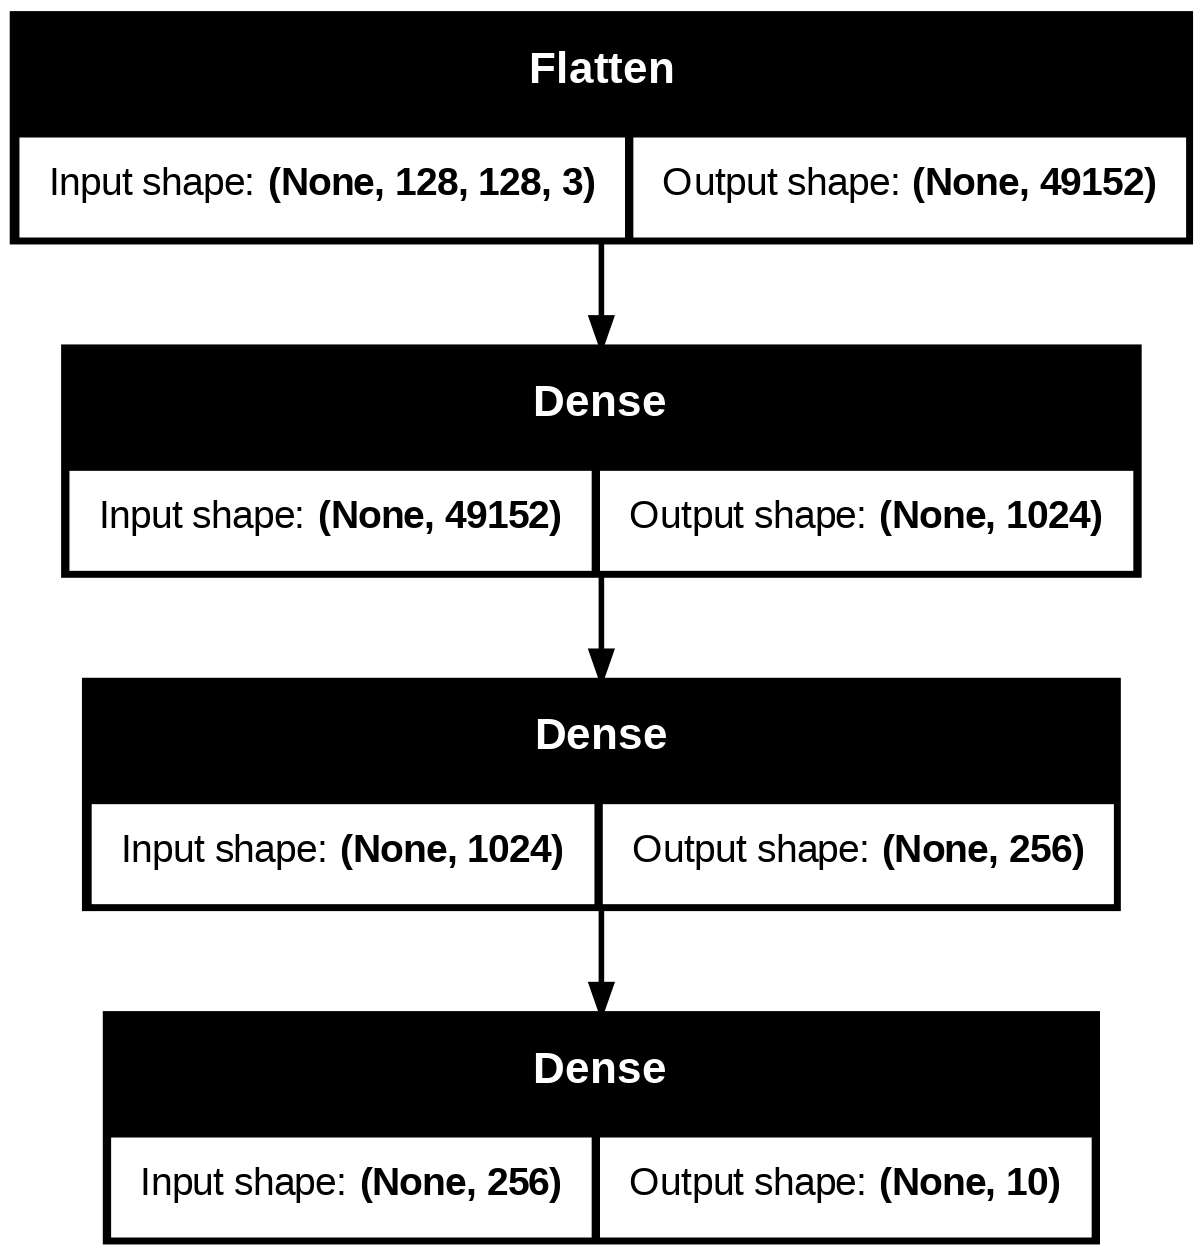

In [13]:
tf.keras.utils.plot_model(model, to_file="model_ann.png", show_shapes=True)

In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.5459 - loss: 1.3785 - val_accuracy: 0.4340 - val_loss: 1.7642
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5476 - loss: 1.3553 - val_accuracy: 0.4604 - val_loss: 1.6044
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5770 - loss: 1.2790 - val_accuracy: 0.3871 - val_loss: 1.8008
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5740 - loss: 1.3190 - val_accuracy: 0.4927 - val_loss: 1.5444
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.6022 - loss: 1.1516 - val_accuracy: 0.4897 - val_loss: 1.5786
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6075 - loss: 1.1641 - val_accuracy: 0.3930 - val_loss: 1.8863
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.5855 - loss: 1.2472 - val_accuracy: 0.4692 - val_loss: 1.6625
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.6016 - loss: 1.1660 - val_accuracy: 0.4604 

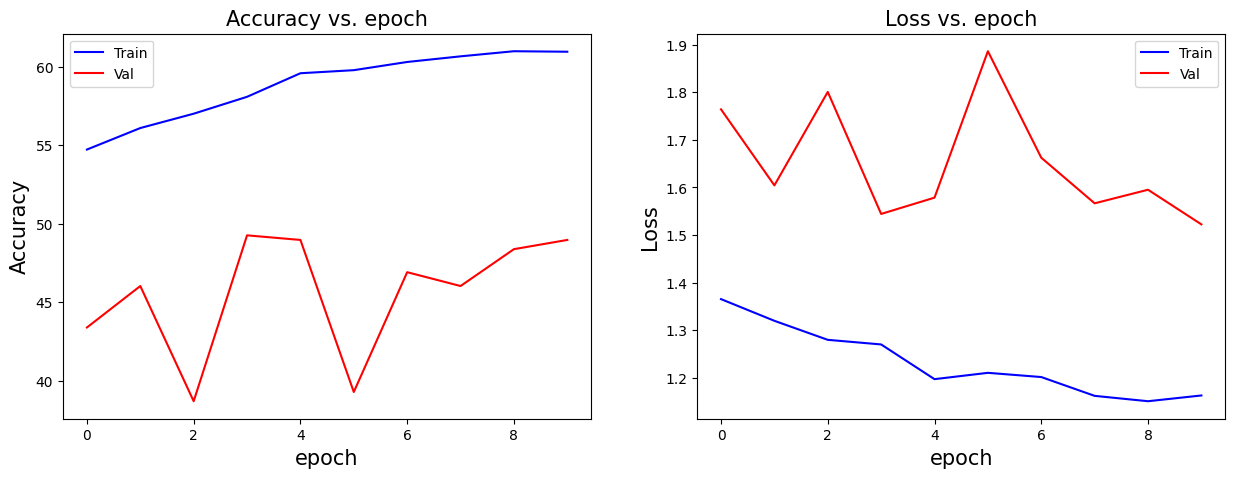

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax = axes.ravel()

#accuracy graph
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['accuracy']], label='Train', color='b')
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val', color='r')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['loss'], label='Train', color='b')
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['val_loss'], label='Val', color='r')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

In [20]:
# load model from pretrained checkpoints (optional)
# model.load_weights("/content/Saved Models/L1_ann_model.ckpt")

# run model prediction and obtain probabilities
y_pred = model.predict(test_ds)

# get list of predicted classes by taking argmax of the probabilities(y_pred)
predicted_categories = tf.argmax(y_pred, axis=1)

# get list of class names
class_names = test_data.class_names

# create list of all "y"s labels, by iterating over test dataset
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# calculate accuracy
test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step

Test Accuracy: 40.32%



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


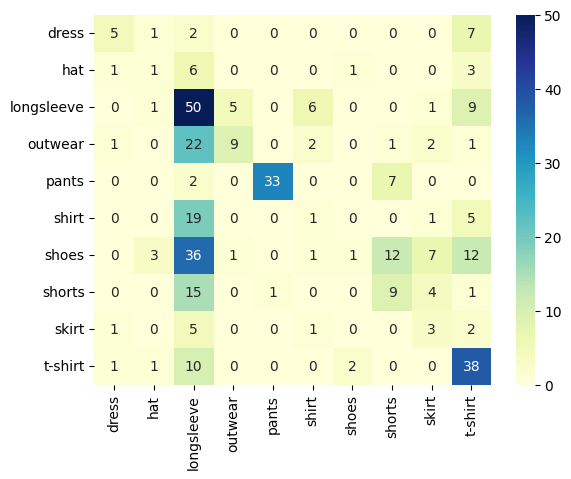

In [21]:
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    # run model prediction and obtain probabilities
    y_pred = model.predict(ds)
    # get list of predicted classes by taking argmax of the probabilities(y_pred)
    predicted_categories = tf.argmax(y_pred, axis=1)
    # create list of all "y"s labels, by iterating over test dataset
    true_categories = tf.concat([y for x, y in ds], axis=0)
    # generate confusion matrix and plot it
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()

ConfusionMatrix(model, test_ds, test_data.class_names)

In [22]:
# function to plot image given image, its true label and class probabilities (pred_array)
def plot_image(pred_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                class_names[true_label]),
                                color=color)

# function to plot barplot of class probabilities (pred_array)
def plot_value_array(pred_array, true_label):
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), pred_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(pred_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


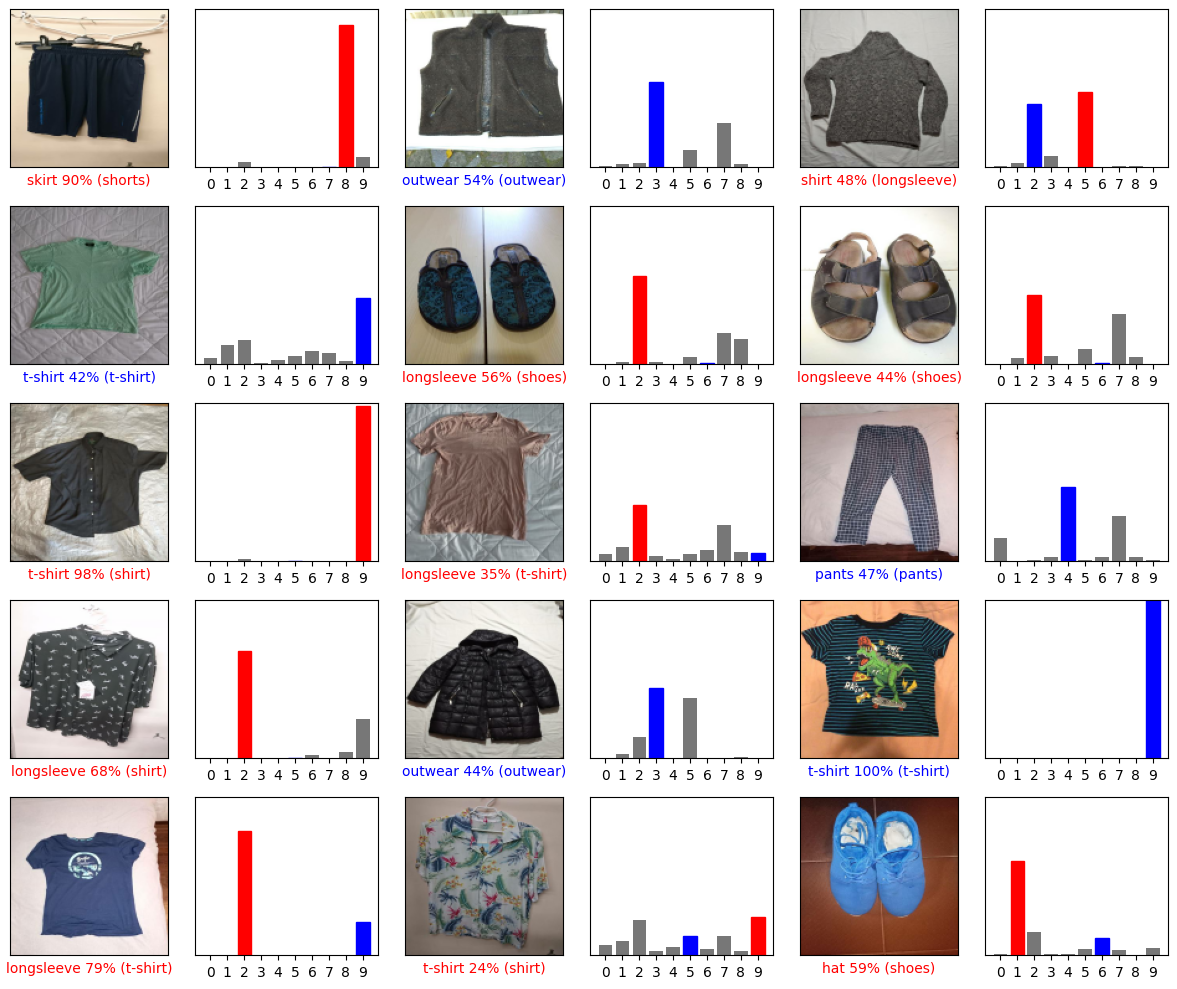

In [23]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()

# CNN:

In [24]:
num_classes = 10
hidden_size = 256

model = keras.Sequential(
    name="model_cnn",
    layers=[
        layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same", activation='relu', input_shape=(height, width, 3)),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(units=hidden_size, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')
    ]
)

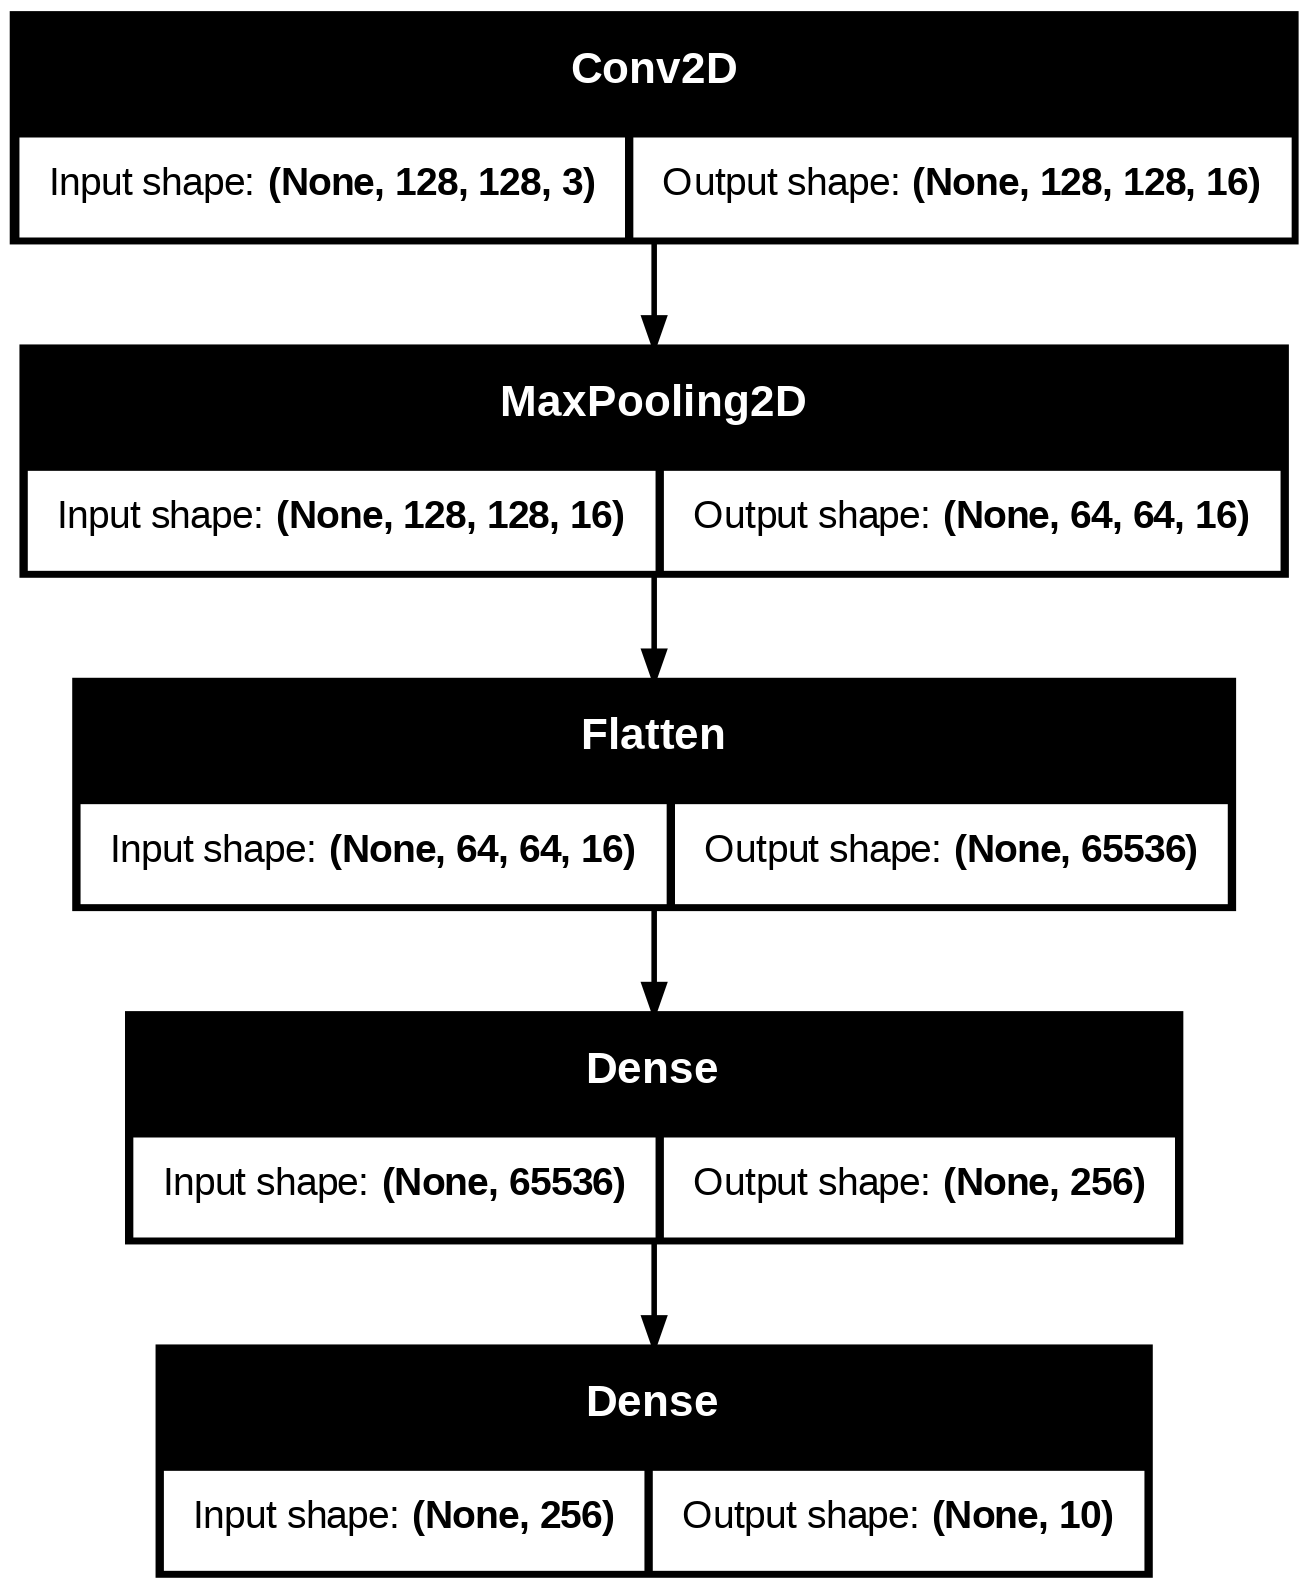

In [25]:
tf.keras.utils.plot_model(model, to_file="model_cnn.png", show_shapes=True)

In [26]:
model.summary()

Model: "model_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,780,490 (64.01 MB)

 Trainable params: 16,780,490 (64.01 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
epochs = 10
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.2058 - loss: 8.4699 - val_accuracy: 0.3519 - val_loss: 2.0018
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.4082 - loss: 1.8251 - val_accuracy: 0.4516 - val_loss: 1.7813
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5402 - loss: 1.4650 - val_accuracy: 0.5191 - val_loss: 1.5624
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.6411 - loss: 1.1327 - val_accuracy: 0.5073 - val_loss: 1.5442
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.7257 - loss: 0.8895 - val_accuracy: 0.5191 - val_loss: 1.5293
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8040 - loss: 0.6903 - val_accuracy: 0.5455 - val_loss: 1.4952
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8878 - loss: 0.4397 - val_accuracy: 0.5484 - val_loss: 1.6246
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9340 - loss: 0.3181 - val_accuracy: 0.5367 - 

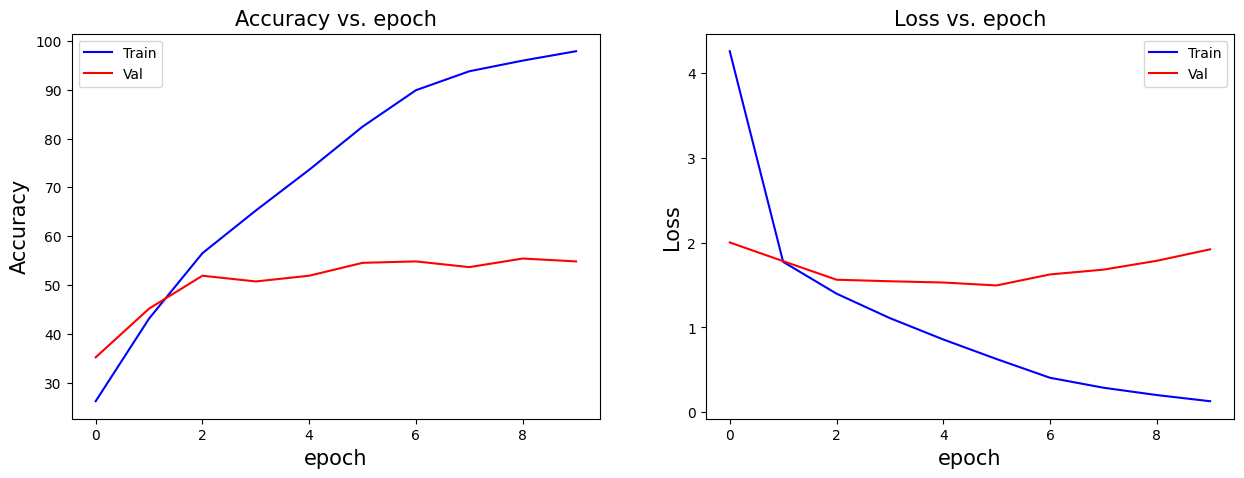

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
ax = axes.ravel()

#accuracy graph
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['accuracy']], label='Train', color='b')
ax[0].plot(range(0,model_fit.params['epochs']), [acc * 100 for acc in model_fit.history['val_accuracy']], label='Val', color='r')
ax[0].set_title('Accuracy vs. epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_xlabel('epoch', fontsize=15)
ax[0].legend()

#loss graph
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['loss'], label='Train', color='b')
ax[1].plot(range(0,model_fit.params['epochs']), model_fit.history['val_loss'], label='Val', color='r')
ax[1].set_title('Loss vs. epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].set_xlabel('epoch', fontsize=15)
ax[1].legend()

#display the graph
plt.show()

In [31]:
# load model from pretrained checkpoints (optional)
# model.load_weights("/content/Saved Models/L1_cnn_model.ckpt")

true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names
predicted_categories = tf.argmax(y_pred, axis=1)

test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
print(f'\nTest Accuracy: {test_acc:.2f}%\n')

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

Test Accuracy: 45.70%



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


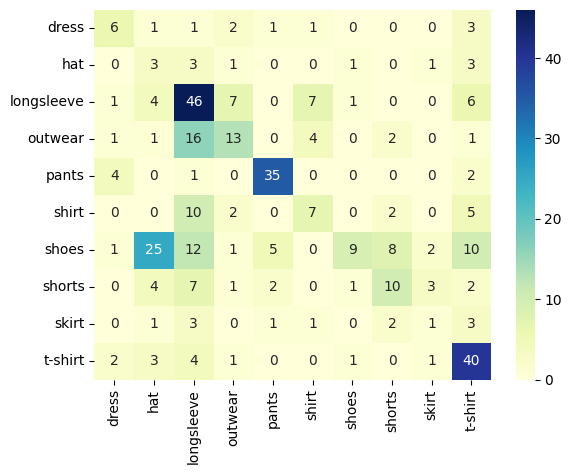

In [32]:
ConfusionMatrix(model, test_ds, test_data.class_names)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


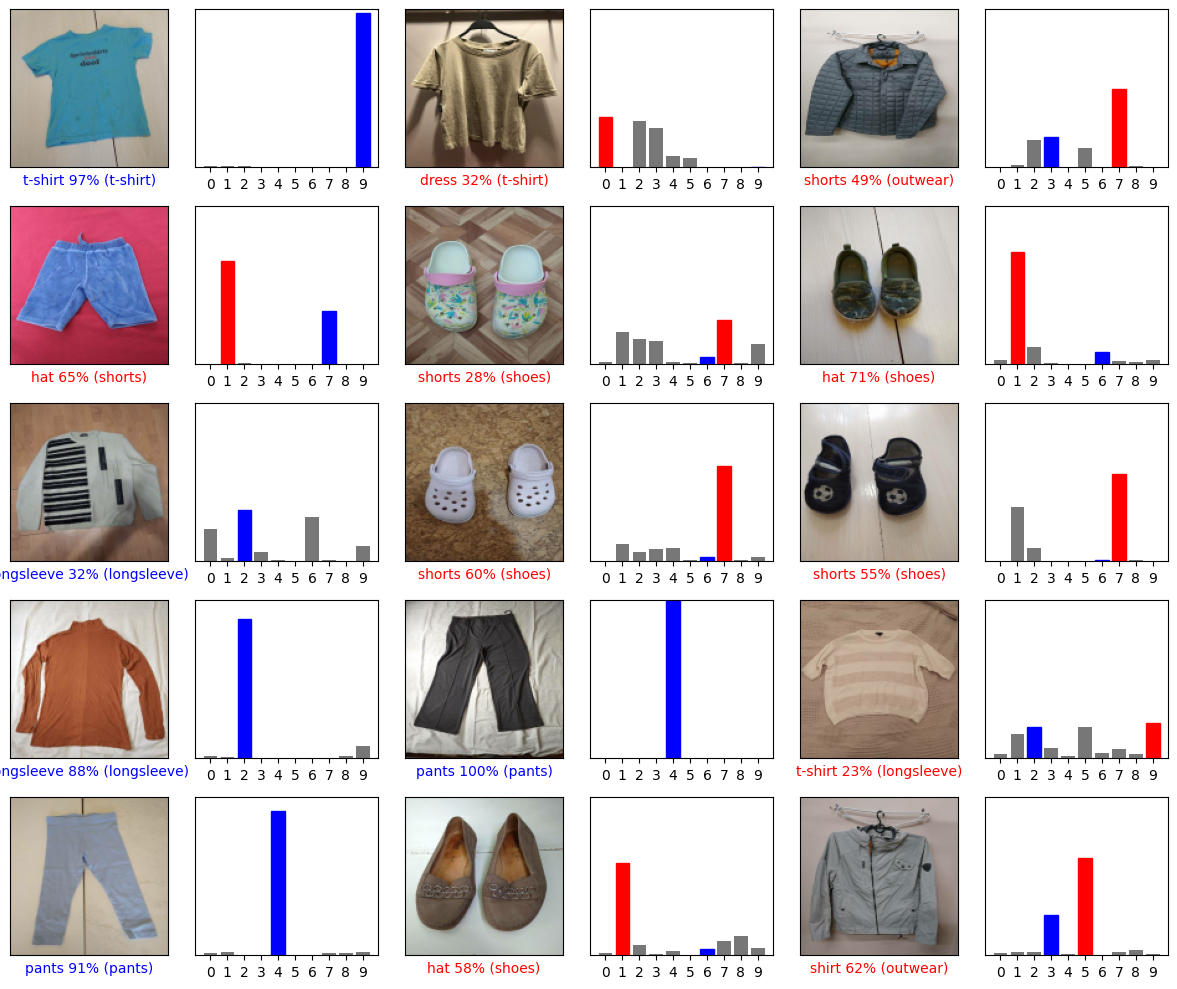

In [33]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)
images = tf.concat([x for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
class_names = test_data.class_names

# Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
indices = random.sample(range(len(images)), 15)
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,index in enumerate(indices):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(y_pred[index], true_categories[index], images[index])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(y_pred[index], true_categories[index])
plt.tight_layout()
plt.show()